In [17]:


#%%
import os
import sys
import json
from argparse import ArgumentParser
import yaml
import torch
import random
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
# personal files
import models
from datasets import MelDataset, vctkDataset, greatbirdDataset, finchbird2, western_bird


os.chdir('/mnt/work/')
# ------------------------------------------------------------------------
# config loading
data_config_path = "./Animal/configs/finch_bird2/dataset_finch_bird2_chunk.yaml"

# model path
model_config_path = "./Animal/configs/finch_bird2/model_finch_bird2.yaml"
model_path = './Animal/output/finch_bird2'
# model name
#------------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_1-c_100.0_1.0-i_10.0_100.0'
# checkpoint = "190000.pth.tar"
# key_posi = [10, 18, 22, 23, 24, 29, 34, 41, 44, 56, 57, 61, 63, 85, 87, 90, 92, 96, 116, 118, 121, 122, 127]
#------------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_1-c_100.0_0.75-i_10.0_100.0'
# checkpoint = "280000.pth.tar"
# key_posi = [10, 18, 22, 23, 24, 29, 34, 41, 44, 56, 57, 61, 63, 85, 87, 90, 92, 96, 116, 118, 121, 122, 127]
#------------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_2-c_100.0_1.1-i_10.0_60.0'
# checkpoint = "280000.pth.tar"
# key_posi = [10, 18, 22, 23, 24, 29, 34, 41, 44, 56, 57, 61, 63, 85, 87, 90, 92, 96, 116, 118, 121, 122, 127]
#------------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_4-c_100.0_0.5-i_10.0_80.0'
# checkpoint = "300000.pth.tar"
# key_posi = [10, 18, 22, 23, 24, 29, 34, 41, 44, 56, 57, 61, 63, 85, 87, 90, 92, 96, 116, 118, 121, 122, 127]
#------------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_5-c_100.0_0.1-i_10.0_20.0'
# checkpoint = "300000.pth.tar"
# key_posi = [10, 18, 22, 23, 24, 29, 34, 41, 44, 56, 57, 61, 63, 85, 87, 90, 92, 96, 116, 118, 121, 122, 127]
#------------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_6-c_100.0_0.5-i_10.0_80.0'
# checkpoint = "180000.pth.tar"
# key_posi = [10, 18, 22, 23, 24, 29, 34, 41, 44, 56, 57, 61, 63, 85, 87, 90, 92, 96, 116, 118, 121, 122, 127]
#-----------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_7-c_100.0_1.0-i_10.0_60.0'
# checkpoint = "180000.pth.tar"
# key_posi = [10, 18, 22, 23, 24, 29, 34, 41, 44, 56, 57, 61, 63, 85, 87, 90, 92, 96, 116, 118, 121, 122, 127]
#-----------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_8-c_100.0_1.0-i_10.0_120.0'
# checkpoint = "100000.pth.tar"
# key_posi = [10, 18, 22, 23, 24, 29, 34, 41, 44, 56, 57, 61, 63, 85, 87, 90, 92, 96, 116, 118, 121, 122, 127]
#-----------------------------------------------------------------------
exp_name = 'VAEbase-finch_bird2_10-c_100.0_0.2-i_10.0_80.0'
checkpoint = "200000.pth.tar"
key_posi = [10, 18, 22, 23, 24, 29, 34, 41, 44, 56, 57, 61, 63, 85, 87, 90, 92, 96, 116, 118, 121, 122, 127]

# device
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# ------------------------------------------------------------------------

# dataset vctk
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
analy_set = finchbird2(dataset_config, subset='test')


analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)

# model loading
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(model_config, device).to(device) # model config load

#load model
save_path = os.path.join(model_path, exp_name, 'checkpoint', checkpoint)
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()

# data store
total_z_indi_mu = []
total_z_indi_log_std = []
total_z_indi = []

total_z_con_mu = []
total_z_con_log_std = []
total_z_con = []

total_x_gt = [] # mel
total_x_rec = [] # reconstuct mel
total_cID = []
total_ctID = []

total_key_indi_mu = []

for mel, lenx, indi_mel, cID, cID_type in tqdm(analy_loader):
        mel = mel.to(device)
        lenx = lenx.to(device)
        indi_mel = indi_mel.to(device)
        
        outputs = model(mel, lenx, indi_mel) 
        
        z_indi_mu = outputs['indi_mu'].detach().cpu().numpy()
        z_indi_log_std = outputs['indi_log_std'].detach().cpu().numpy()
        z_indi = outputs['z_indi'].detach().cpu().numpy() 
                
        z_con_mu = outputs['con_mu'].detach().cpu().numpy() 
        z_con_log_std = outputs['con_log_std'].detach().cpu().numpy() 
        z_con = outputs['z_con'].detach().cpu().numpy() 
        x_rec = outputs['x_rec'].detach().cpu().numpy() 
        
        total_z_indi_mu.append(z_indi_mu)
        # extracte key position of total_z_indi_mu [:,11] 
        total_key_indi_mu.append([z_indi_mu[:,i] for i in key_posi])
        
        total_z_indi_log_std.append(z_indi_log_std)
        total_z_indi.append(z_indi)
        total_z_con_mu.append(z_con_mu)
        total_z_con_log_std.append(z_con_log_std)
        total_z_con.append(z_con)
        
        total_x_gt.append(mel.detach().cpu().numpy())
        total_x_rec.append(x_rec)
        
        # print('cID',cID[0][1:])
        total_cID.append(cID[0])
        total_ctID.append(cID_type[0])
        
        
    
unique_elements, counts = np.unique(total_cID, return_counts=True)
times = 0
for element, count in zip(unique_elements, counts):
    times += 1
    print('cID_counts',f"{element}: {count}")
print('times',times)

unique_elements, counts = np.unique(total_ctID, return_counts=True)
for element, count in zip(unique_elements, counts):
    times += 1
    print('cID_counts',f"{element}: {count}")


dataset finchbird loading...


 16%|█▌        | 3483/21591 [00:02<00:10, 1678.84it/s]

100%|██████████| 21591/21591 [03:53<00:00, 92.63it/s] 


cID_counts Bird0: 774
cID_counts Bird1: 3584
cID_counts Bird10: 587
cID_counts Bird2: 2628
cID_counts Bird3: 2955
cID_counts Bird4: 2693
cID_counts Bird5: 2059
cID_counts Bird6: 1770
cID_counts Bird7: 2081
cID_counts Bird8: 503
cID_counts Bird9: 1957
times 11
cID_counts 0_Bird0: 194
cID_counts 0_Bird1: 882
cID_counts 0_Bird10: 50
cID_counts 0_Bird2: 554
cID_counts 0_Bird3: 607
cID_counts 0_Bird4: 639
cID_counts 0_Bird5: 399
cID_counts 0_Bird6: 418
cID_counts 0_Bird7: 1051
cID_counts 0_Bird8: 187
cID_counts 0_Bird9: 248
cID_counts 1_Bird0: 63
cID_counts 1_Bird1: 518
cID_counts 1_Bird10: 41
cID_counts 1_Bird2: 125
cID_counts 1_Bird3: 94
cID_counts 1_Bird4: 181
cID_counts 1_Bird5: 330
cID_counts 1_Bird6: 642
cID_counts 1_Bird7: 209
cID_counts 1_Bird8: 273
cID_counts 1_Bird9: 169
cID_counts 2_Bird0: 77
cID_counts 2_Bird1: 507
cID_counts 2_Bird10: 70
cID_counts 2_Bird2: 78
cID_counts 2_Bird3: 773
cID_counts 2_Bird4: 1115
cID_counts 2_Bird5: 505
cID_counts 2_Bird6: 502
cID_counts 2_Bird7: 35

['Bird0' 'Bird1' 'Bird10' 'Bird2' 'Bird3' 'Bird4' 'Bird5' 'Bird6' 'Bird7'
 'Bird8' 'Bird9']
[   0    1    2 ... 4355 4356 4357]
cID_counts 0_Bird0: 1
type number 1
cID_counts 0_Bird1: 1
type number 1


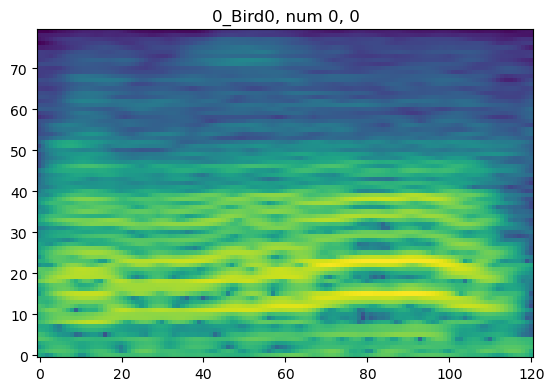

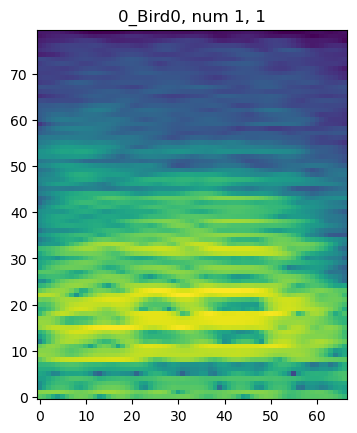

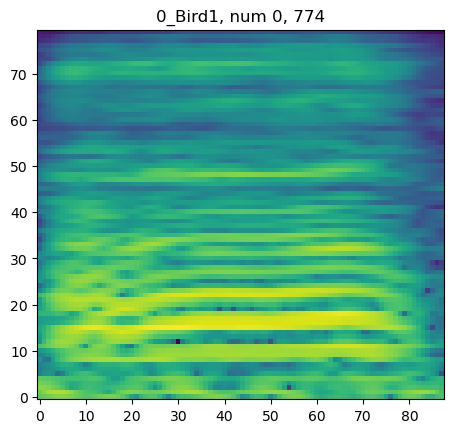

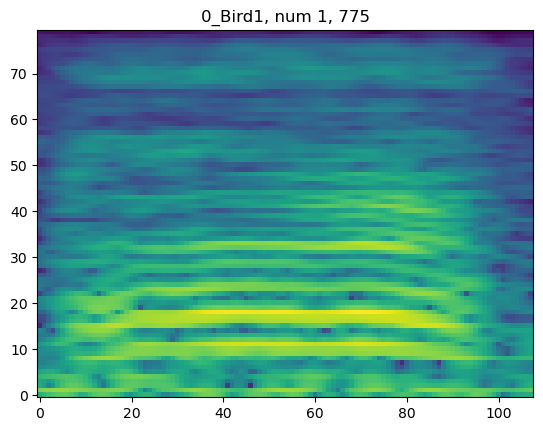

In [18]:

# used_label = total_ctID
from enum import unique


total_caller = np.unique(total_cID)
print(total_caller)
# used_caller = ['B101', 'B165', 'B221', 'B39', 'B4']
# ['B101' 'B165' 'B221' 'B39' 'B4' 'B57' 'B67' 'B98' 'C1' 'C10' 'C108'
#  'C109' 'C12' 'C16' 'C4' 'C47' 'C61A' 'EX10' 'EX19A' 'EX29' 'EX34' 'EX51'
#  'EX57' 'EX62' 'EX62E' 'EX62F' 'MP12' 'MP29' 'MP41' 'MP42' 'MP50' 'MP55'
#  'MP57' 'MP61' 'MP64' 'MP65' 'MP76' 'MP78' 'O113' 'O21' 'O27A' 'O36' 'O48'
#  'O56' 'O6' 'O75D' 'O78' 'O82' 'O93' 'P11' 'P6' 'SW1' 'SW102' 'SW114'
#  'SW128' 'SW19' 'SW28' 'SW32' 'SW34' 'SW49' 'SW60' 'SW9' 'W103A' 'W17'
#  'W18' 'W28' 'W35' 'W36' 'W67' 'W73' 'W80']


# choosed caller
used_caller = ['Bird0', 'Bird1']
# used_caller = ['B57', 'W28', 'SW114']
# used_caller = ['W28', 'SW32', 'C16']
# used_caller = ['SW1']

mask_caller = np.isin(total_cID, used_caller)
caller_indices = np.where(mask_caller)
print(caller_indices[0])

max_index = 2

for caller in used_caller:
    mask_caller = np.isin(total_cID, caller)
    caller_indices = np.where(mask_caller)[0]
    unique_elements, counts = np.unique(total_ctID[caller_indices[0]], return_counts=True)
    times = 0
    for element, count in zip(unique_elements, counts):
        times += 1
        print('cID_counts',f"{element}: {count}")
    print('type number',times)   


for caller in used_caller:
    # caller id
    mask_caller = np.isin(total_cID, caller)
    caller_indices = np.where(mask_caller)[0]
    # print(caller_indices)
    # caller type 

    unique_caller_type = np.unique(total_ctID[caller_indices[0]])
    for type in unique_caller_type:
        mask_caller_type = np.isin(total_ctID, type)
        caller_type_indices = np.where(mask_caller_type)[0]
        # print('caller_type_indices',caller_type_indices)
        index = 0
        for i in caller_type_indices:
            plt.imshow(total_x_gt[i][0], origin = 'lower')
            plt.title('{}, num {}, {}'.format(total_ctID[i], index, i))  
            plt.show()
            if index + 1 >= max_index:
                break
            index += 1
        
# used_label_index = unique_labels[rand_label]

# i = 5
# plt.imshow(total_x_gt[caller_type_indices[i]][0], origin = 'lower')
# plt.title('{} {}'.format(total_ctID[caller_type_indices[i]], i)) 

# plt.show()

In [19]:
used_label = total_ctID
unique_labels = np.unique(used_label)
print(len(unique_labels))

93


In [20]:
from sklearn.manifold import TSNE

# call type
total_z_con_1D = []
for i in total_z_con_mu: # total_z_con; content miu: total_z_con_mu; content var: total_z_con_log_std
    total_z_con_1D.append(i.sum(2))
    # total_z_con_1D.append(i.mean(2))

# tsne
total_z_con_1D = np.array(total_z_con_1D).squeeze()
tsne = TSNE(n_components = 2, perplexity = 30, n_iter = 1000)

# print('total_z_con_1D',total_z_con_1D[0])

data_2d_con = tsne.fit_transform(total_z_con_1D) # cnontent


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data choose from label (19510, 2)
label choose from label (1, 19510)
unique label choose from label (10,)


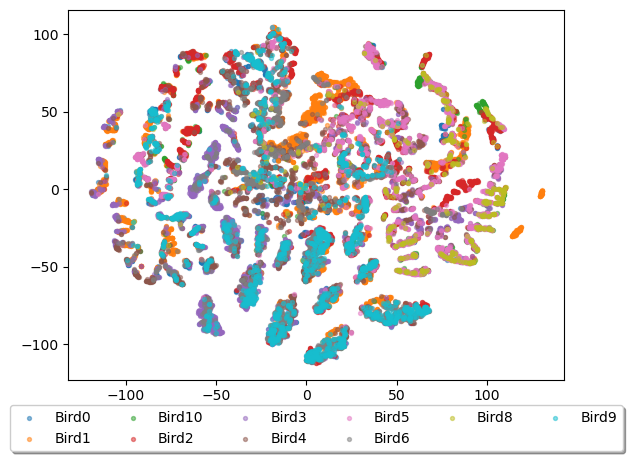

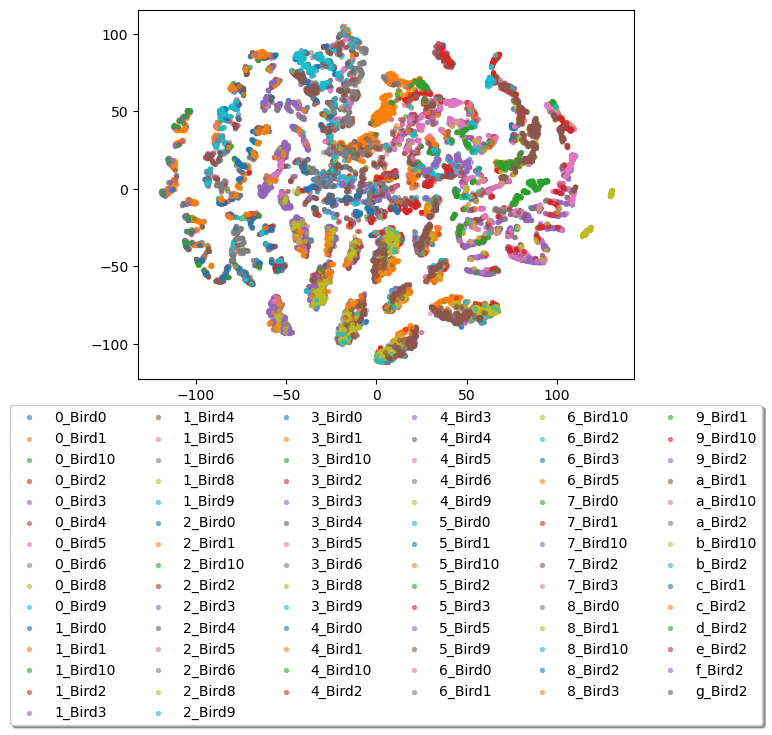

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data choose from label (2059, 2)
label choose from label (1, 2059)
unique label choose from label (1,)


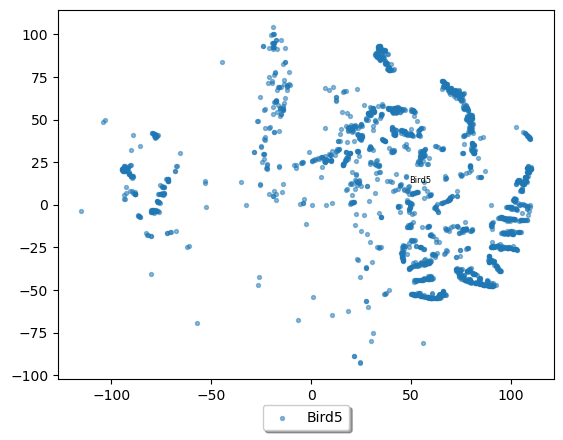

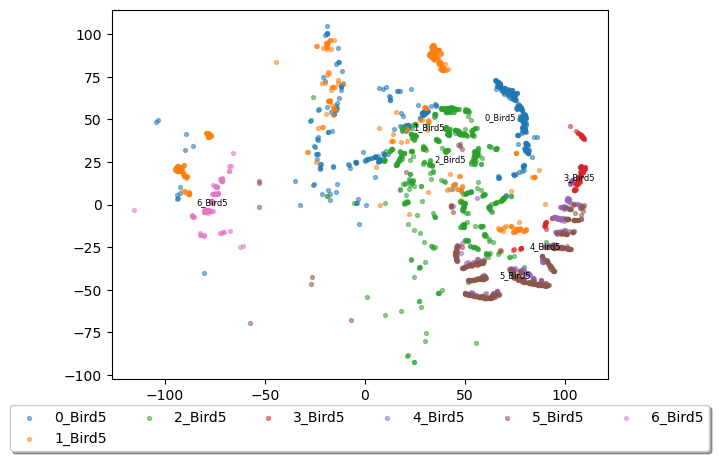

In [21]:

# Get unique labels
# caller
total_cID = np.array(total_cID)
used_label = np.expand_dims(total_cID, axis=0)

# caller_class
total_ctID = np.array(total_ctID)
caller_type_label = np.expand_dims(total_ctID, axis=0)
# ------------------------------------------------------------------------
# use data segment
# ran_data = True
ran_data = False
if ran_data:
    num_samples = 5000
    random.seed(0)
    rand = list(range(len(data_2d_con)))
    samples = random.sample(rand, num_samples)
    data_2d_con_seg = data_2d_con[samples,]
    used_label_seg = used_label[:,samples]
    unique_labels = np.unique(used_label_seg)
else:
    # not random choose data segment
    data_2d_con_seg = data_2d_con
    used_label_seg = used_label
    unique_labels = np.unique(used_label_seg)
    # print(data_2d_con.shape)
    # print(unique_labels.shape)
    # print(unique_labels)


# select data from data label
# random select
# num_label = 5
# num_label = 71


con_text = [False, True]
con_iter = iter(con_text) 

for num_label in [10, 1]: 
    
    random.seed(0)
    rand_label_num = list(range(len(unique_labels)))
    print(rand_label_num)
    rand_label = random.sample(rand_label_num, num_label)
    used_label_index = unique_labels[rand_label]

    # choose label
    # used_label_index = ['B101', 'B165',  'B221',  'B39',  'B4', 'B57']
    # ['B101' 'B165' 'B221' 'B39' 'B4' 'B57' 'B67' 'B98' 'C1' 'C10' 'C108'
    #  'C109' 'C12' 'C16' 'C4' 'C47' 'C61A' 'EX10' 'EX19A' 'EX29' 'EX34' 'EX51'
    #  'EX57' 'EX62' 'EX62E' 'EX62F' 'MP12' 'MP29' 'MP41' 'MP42' 'MP50' 'MP55'
    #  'MP57' 'MP61' 'MP64' 'MP65' 'MP76' 'MP78' 'O113' 'O21' 'O27A' 'O36' 'O48'
    #  'O56' 'O6' 'O75D' 'O78' 'O82' 'O93' 'P11' 'P6' 'SW1' 'SW102' 'SW114'
    #  'SW128' 'SW19' 'SW28' 'SW32' 'SW34' 'SW49' 'SW60' 'SW9' 'W103A' 'W17'
    #  'W18' 'W28' 'W35' 'W36' 'W67' 'W73' 'W80']

    # mask to selected data label
    mask = np.isin(used_label_seg, used_label_index)
    # print(mask)
    indices = np.where(mask)[1]
    # print(indices)
    data_spk_label = data_2d_con_seg[indices,]
    used_spk_label = used_label_seg[:,indices]
    used_spk_type_label = caller_type_label[:,indices]

    unique_spk_label = np.unique(used_spk_label)
    unique_spk_type_label = np.unique(used_spk_type_label)

    print('data choose from label',data_spk_label.shape)
    # print(data_spk_label)
    print('label choose from label',used_spk_label.shape)
    # print(used_spk_label)
    print('unique label choose from label',unique_spk_label.shape)
    # print(unique_spk_label)

    # paint index
    next_item = next(con_iter)
    
    for label in unique_spk_label:
        label_mask = np.all(used_spk_label == label, axis=0)
        
        # print('label',label)
        # print(label_mask)
        # Select data for this label
        data_for_label = data_spk_label[label_mask]
        
        # Plot the data for this label with a label for the legend
        plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

        # center prosition
        centroid = np.median(data_for_label, axis=0)
        # text label
        if next_item:
            plt.text(centroid[0], centroid[1], str(label), fontsize=6, color='black', ha='center', va='center')

    # Add a legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
    plt.show()


    for label in unique_spk_type_label:
        label_mask = np.all(used_spk_type_label == label, axis=0)
        
        # print('label',label)
        # print(label_mask)
        # Select data for this label
        data_for_label = data_spk_label[label_mask]
        
        # Plot the data for this label with a label for the legend
        plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

        # center prosition
        centroid = np.median(data_for_label, axis=0)
        # text label
        if next_item:
            plt.text(centroid[0], centroid[1], str(label), fontsize=6, color='black', ha='center', va='center')

    # Add a legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
    plt.show()

In [22]:
from sklearn.manifold import TSNE

# total_z_con = 
# caller
total_z_indi = np.array(total_z_indi).squeeze() # indi
total_z_indi_mu = np.array(total_z_indi_mu).squeeze() # individual miu
total_z_indi_log_std = np.array(total_z_indi_log_std).squeeze()
total_indi = np.hstack((total_z_indi_mu, total_z_indi_log_std))
# tsne
tsne = TSNE(n_components=2, perplexity = 30, n_iter = 1000)
data_2d_speaker = tsne.fit_transform(total_z_indi_mu)



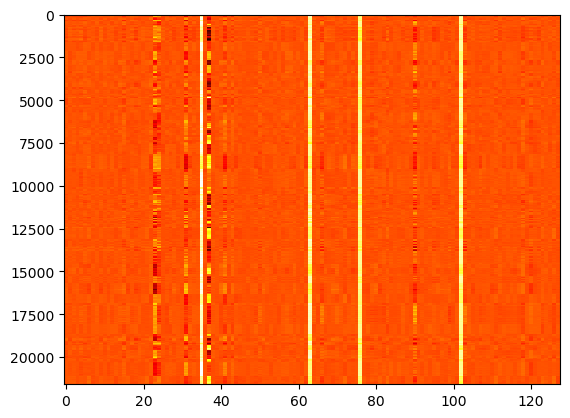

In [23]:
plt.imshow(total_z_indi_mu, aspect='auto', cmap='hot', interpolation='nearest')
plt.show()

data shape (21591, 128)
total label 11 ['Bird0' 'Bird1' 'Bird10' 'Bird2' 'Bird3' 'Bird4' 'Bird5' 'Bird6' 'Bird7'
 'Bird8' 'Bird9']
rand choosed label name 10 ['Bird5' 'Bird9' 'Bird0' 'Bird3' 'Bird6' 'Bird2' 'Bird4' 'Bird10' 'Bird1'
 'Bird8']
data choose from label (19510, 2)
label choose from label (1, 19510)
unique label type choose from label (86,)
unique label choose from label (10,)


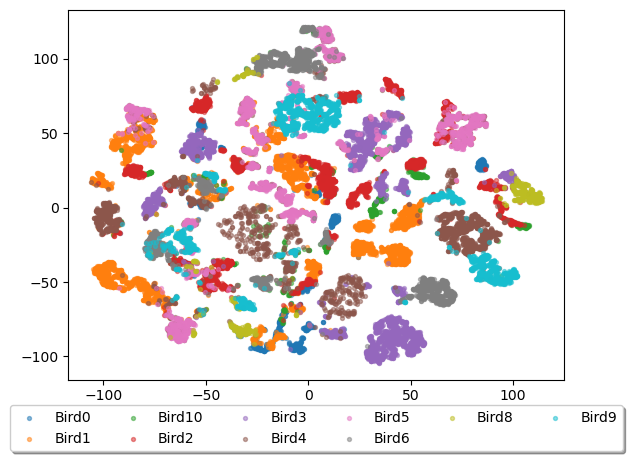

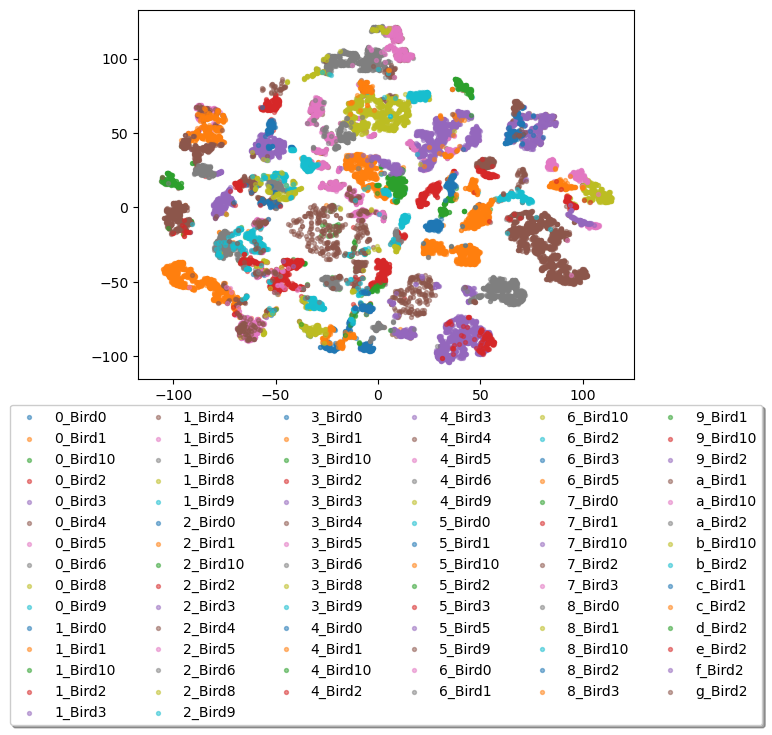

total label 11 ['Bird0' 'Bird1' 'Bird10' 'Bird2' 'Bird3' 'Bird4' 'Bird5' 'Bird6' 'Bird7'
 'Bird8' 'Bird9']
rand choosed label name 5 ['Bird5' 'Bird9' 'Bird0' 'Bird3' 'Bird6']
data choose from label (9515, 2)
label choose from label (1, 9515)
unique label type choose from label (36,)
unique label choose from label (5,)


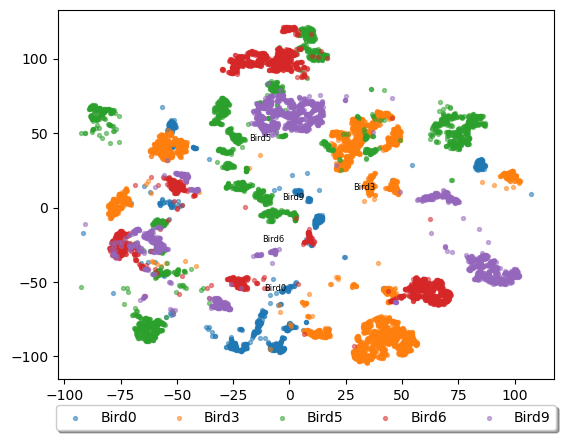

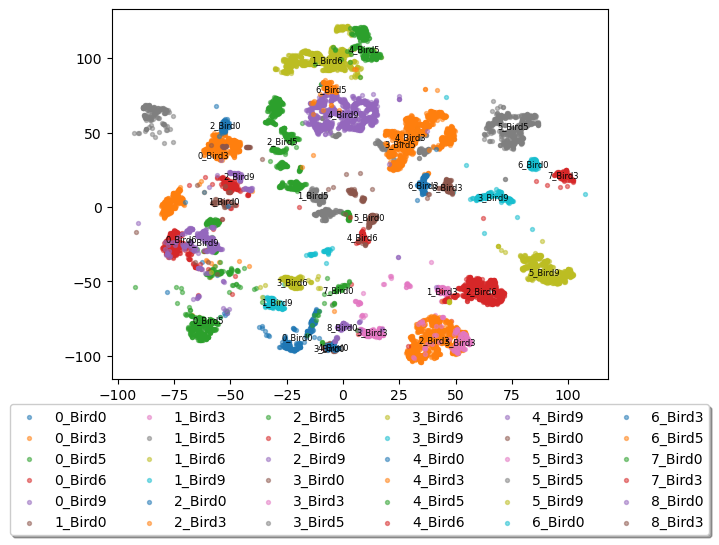

In [24]:
# Get unique labels
# caller
total_cID = np.array(total_cID)
used_label = np.expand_dims(total_cID, axis=0)

# caller_class
total_ctID = np.array(total_ctID)
caller_type_label = np.expand_dims(total_ctID, axis=0)

# use data segment
# ran_data = True
ran_data = False
if ran_data:
    num_samples = 5000
    random.seed(0)
    rand = list(range(len(data_2d_speaker)))
    samples = random.sample(rand, num_samples)
    data_2d_spk_seg = data_2d_speaker[samples,]
    used_label_seg = used_label[:,samples]
    unique_labels = np.unique(used_label_seg)
else:
    # not random choose data segment
    data_2d_spk_seg = data_2d_speaker
    used_label_seg = used_label
    unique_labels = np.unique(used_label_seg)
    # print(data_2d_con.shape)
    # print(unique_labels.shape)
    # print(unique_labels)


# select data from data label
# random select
# num_label = 5
# num_label = 71

# con_text = [False, True]
con_text = [False, True]

con_iter = iter(con_text) 

print('data shape',total_z_indi.shape)

for num_label in [10, 5]: 
    random.seed(0)
    rand_label_num = list(range(len(unique_labels)))
    rand_label = random.sample(rand_label_num, num_label)
    used_label_index = unique_labels[rand_label]

    # choose label
    # used_label_index = ['B101', 'B165',  'B221',  'B39',  'B4', 'B57']
    # ['B101' 'B165' 'B221' 'B39' 'B4' 'B57' 'B67' 'B98' 'C1' 'C10' 'C108'
    #  'C109' 'C12' 'C16' 'C4' 'C47' 'C61A' 'EX10' 'EX19A' 'EX29' 'EX34' 'EX51'
    #  'EX57' 'EX62' 'EX62E' 'EX62F' 'MP12' 'MP29' 'MP41' 'MP42' 'MP50' 'MP55'
    #  'MP57' 'MP61' 'MP64' 'MP65' 'MP76' 'MP78' 'O113' 'O21' 'O27A' 'O36' 'O48'
    #  'O56' 'O6' 'O75D' 'O78' 'O82' 'O93' 'P11' 'P6' 'SW1' 'SW102' 'SW114'
    #  'SW128' 'SW19' 'SW28' 'SW32' 'SW34' 'SW49' 'SW60' 'SW9' 'W103A' 'W17'
    #  'W18' 'W28' 'W35' 'W36' 'W67' 'W73' 'W80']

    print('total label',len(np.unique(used_label)),np.unique(used_label))
    print('rand choosed label name',len(used_label_index),used_label_index)


    # mask to selected data label
    mask = np.isin(used_label_seg, used_label_index)
    # print(mask)
    indices = np.where(mask)[1]
    # print(indices)
    data_spk_label = data_2d_spk_seg[indices,]
    used_spk_label = used_label_seg[:,indices]
    used_spk_type_label = caller_type_label[:,indices]
    unique_spk_label = np.unique(used_spk_label)
    unique_spk_type_label = np.unique(used_spk_type_label)

    print('data choose from label',data_spk_label.shape)
    # print(data_spk_label)
    print('label choose from label',used_spk_label.shape)
    # print(used_spk_label)
    print('unique label type choose from label',unique_spk_type_label.shape)
    print('unique label choose from label',unique_spk_label.shape)
    # print(unique_spk_label)

    # paint index
    next_item = next(con_iter)
    
    for label in unique_spk_label:
        label_mask = np.all(used_spk_label == label, axis=0)
        
        # print('label',label)
        # print(label_mask)
        # Select data for this label
        data_for_label = data_spk_label[label_mask]
        
        # Plot the data for this label with a label for the legend
        plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

        # center prosition
        centroid = np.median(data_for_label, axis=0)
        # text label
        if next_item:
            plt.text(centroid[0], centroid[1], str(label), fontsize=6, color='black', ha='center', va='center')

    # Add a legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
    plt.show()


    for label in unique_spk_type_label:
        label_mask = np.all(used_spk_type_label == label, axis=0)
        
        # print('label',label)
        # print(label_mask)
        # Select data for this label
        data_for_label = data_spk_label[label_mask]
        
        # Plot the data for this label with a label for the legend
        plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

        # center prosition
        # centroid = np.mean(data_for_label, axis=0)
        centroid = np.median(data_for_label, axis=0)
        # text label
        if next_item:
            plt.text(centroid[0], centroid[1], str(label), fontsize=6, color='black', ha='center', va='center')

    # Add a legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
    plt.show()



In [25]:
import pandas as pd

em_save = True
em_save = False

if em_save:
    ## save
    embed_save_path = os.path.join(model_path, exp_name, 'embedding')

    if not os.path.exists(embed_save_path):
        os.makedirs(embed_save_path)
        
    # data
    print(total_z_indi_mu.shape)
    save_df = pd.DataFrame(total_z_indi_mu)
    save_df.to_csv(os.path.join(model_path, exp_name, 'embedding', 'embedding.csv'), index=False, header=False)

    # caller label save
    caller_df = pd.DataFrame(total_cID)
    caller_df.to_csv(os.path.join(model_path, exp_name, 'embedding', 'caller_label.csv'), index=False, header=False)
    
    # caller type label save
    caller_type_df = pd.DataFrame(total_ctID) 
    caller_type_df.to_csv(os.path.join(model_path, exp_name, 'embedding', 'caller_type_label.csv'), index=False, header=False)



In [26]:
total_ctID

array(['0_Bird0', '0_Bird0', '0_Bird0', ..., '5_Bird9', '5_Bird9',
       '5_Bird9'], dtype='<U8')

key_indi_mu (21591, 23)


key_posi_total (21591, 23)


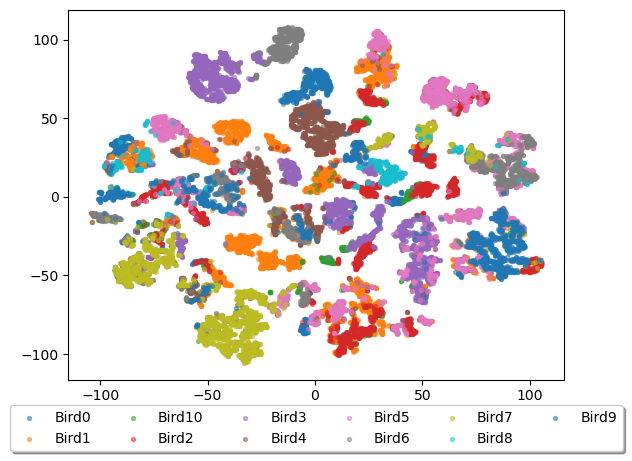

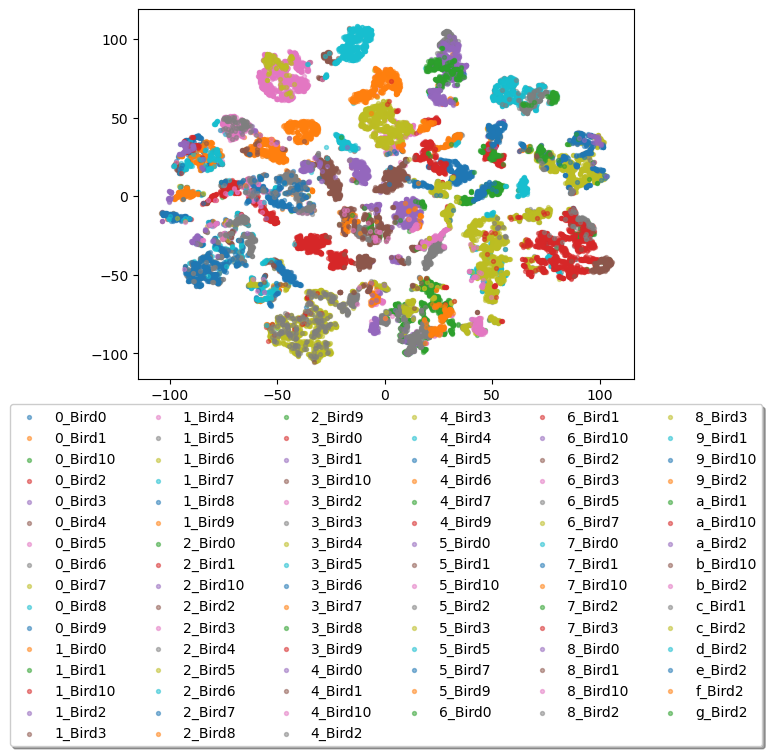

In [27]:
# test key posti of indi miu
from sklearn.manifold import TSNE

# call type
key_indi_mu = np.array(total_key_indi_mu).squeeze()

print('key_indi_mu',key_indi_mu.shape)

# choose some caller vector
# key_indi_mu = key_indi_mu[:,:]
# indics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
# key_indi_mu = key_indi_mu[:,0]

# tsne
tsne = TSNE(n_components = 2, perplexity = 35, n_iter = 1000)
key_posi_total = tsne.fit_transform(key_indi_mu)

print('key_posi_total',key_indi_mu.shape)

key_used_label = np.expand_dims(total_cID, axis=0)
key_unique_labels = np.unique(key_used_label)
# print(key_posi_total.shape)
# print(used_label)
# print(unique_labels)
 
for label in key_unique_labels:
    # 这里我们不需要指定axis，因为used_label只有一行
    label_mask = np.all(key_used_label == label, axis=0)
    # Select data for this label
    data_for_label = key_posi_total[label_mask]
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

# Add a legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
plt.show()

key_used_label = np.expand_dims(total_ctID, axis=0)
key_unique_labels = np.unique(key_used_label)
for label in key_unique_labels:
    # 这里我们不需要指定axis，因为used_label只有一行
    label_mask = np.all(key_used_label == label, axis=0)
    # Select data for this label
    data_for_label = key_posi_total[label_mask]
    # Plot the data for this label with a label for the legend
    plt.scatter(data_for_label[:, 0], data_for_label[:, 1], label=label, alpha=0.5, s=8)

# Add a legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
plt.show()
    

In [28]:
key_indi_mu.shape

(21591, 23)

In [29]:
import pandas as pd

em_save = True
if em_save:
    ## save
    embed_save_path = os.path.join(model_path, exp_name, 'embedding_short')

    if not os.path.exists(embed_save_path):
        os.makedirs(embed_save_path)
        
    # data
    print(key_indi_mu.shape)
    save_df = pd.DataFrame(key_indi_mu)
    save_df.to_csv(os.path.join(model_path, exp_name, 'embedding_short', 'embedding.csv'), index=False, header=False)

    # caller label save
    caller_df = pd.DataFrame(total_cID)
    caller_df.to_csv(os.path.join(model_path, exp_name, 'embedding_short', 'caller_label.csv'), index=False, header=False)
    
    # caller type label save
    caller_type_df = pd.DataFrame(total_ctID) 
    caller_type_df.to_csv(os.path.join(model_path, exp_name, 'embedding_short', 'caller_type_label.csv'), index=False, header=False)



(21591, 23)


In [30]:

# input to model
#%%
import os
import sys
import json
from argparse import ArgumentParser
import yaml
import torch
import random
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
# personal files
import models
from datasets import MelDataset, vctkDataset, greatbirdDataset, finchbird2
from matplotlib.pyplot import ylim
import torch.distributions as D
from itertools import islice


os.chdir('/mnt/work/')
# ------------------------------------------------------------------------
# config loading
data_config_path = "./Animal/configs/finch_bird2/dataset_finch_bird2_chunk.yaml"

# dataset vctk
dataset_config = yaml.load(open(data_config_path, "r"), Loader=yaml.FullLoader)
analy_set = finchbird2(dataset_config, subset='test')
# analy_set = greatbirdDataset(dataset_config, subset='train')

analy_loader = DataLoader(analy_set, batch_size=1, shuffle=False)


# device
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



dataset finchbird loading...


  8%|▊         | 1650/21591 [00:00<00:11, 1713.97it/s]

100%|██████████| 21591/21591 [00:13<00:00, 1587.75it/s]


cID_type: 0_Bird1


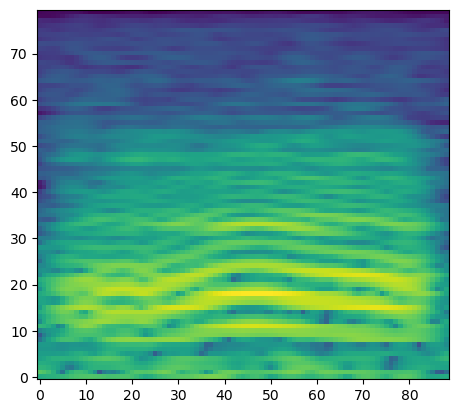

(1, 128)
reconstructed: 0_Bird1


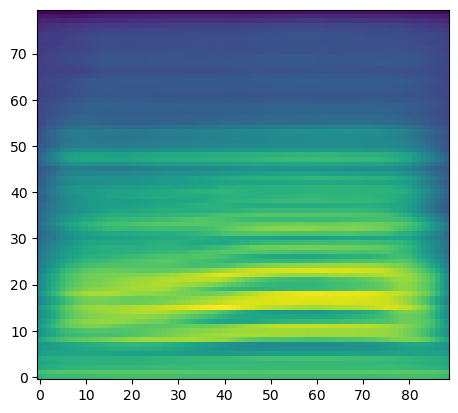

(1, 128)
0.06767247
[-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3]
z_sta -8
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


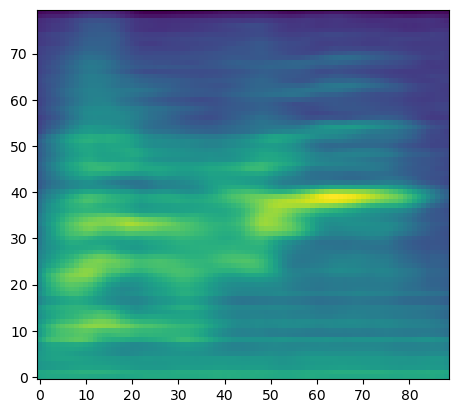

z_sta -7
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


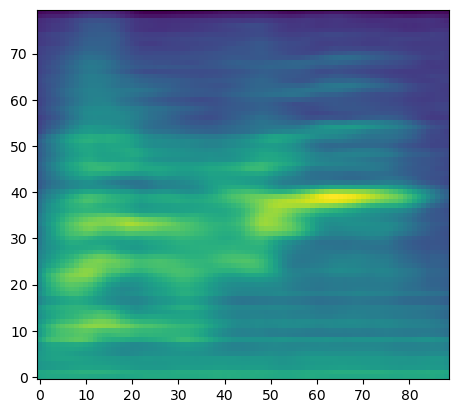

z_sta -6
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


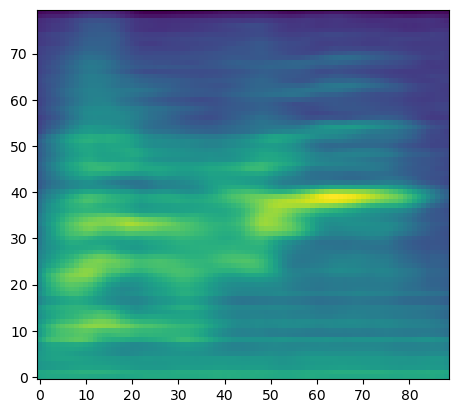

z_sta -5
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


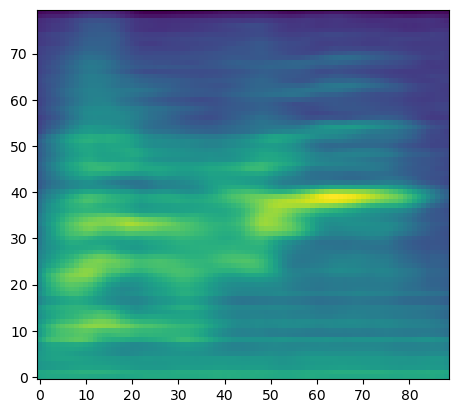

z_sta -4
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


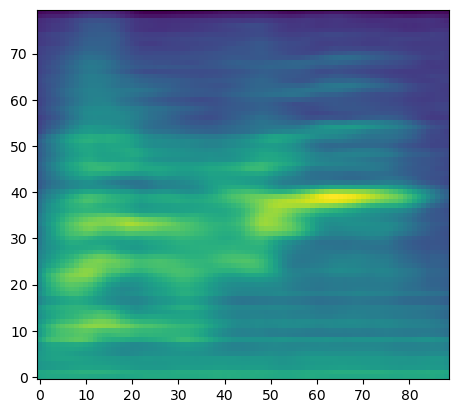

z_sta -3
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


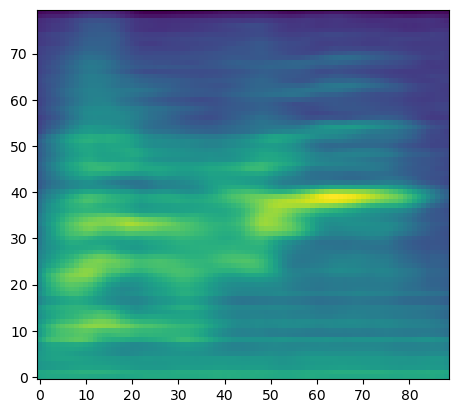

z_sta -2
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


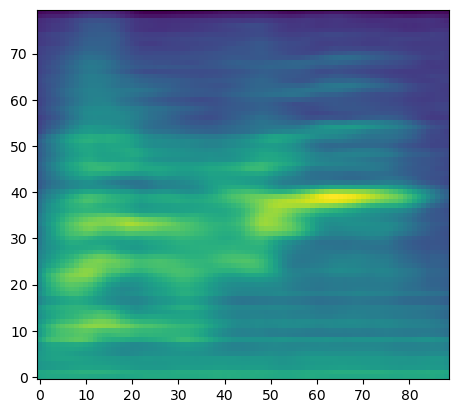

z_sta -1
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


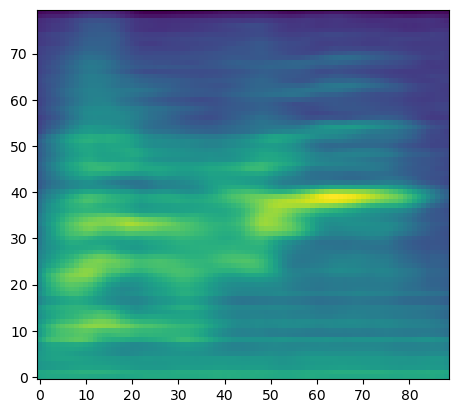

z_sta 0
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


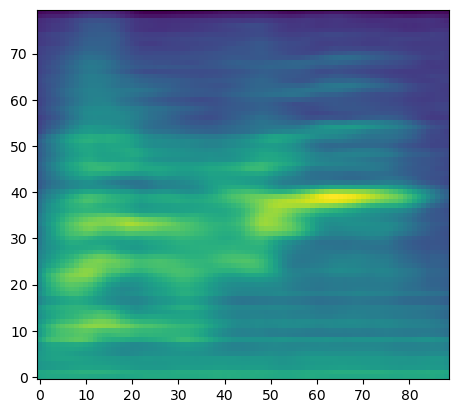

z_sta 1
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


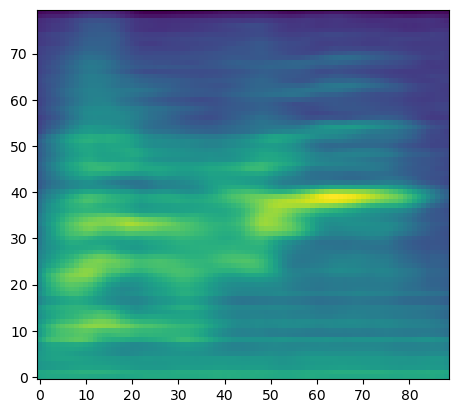

z_sta 2
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


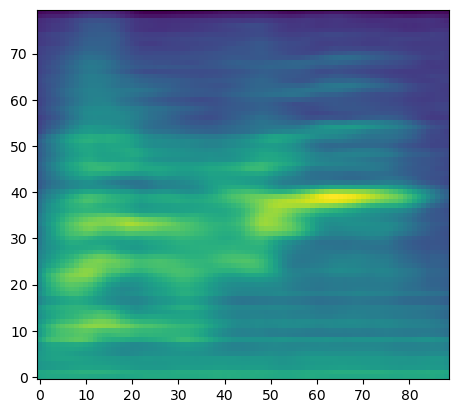

z_sta 3
z_dy torch.Size([1, 128, 89]) z_sta torch.Size([1, 128])
shape torch.Size([1, 128, 89]) torch.Size([1, 128])


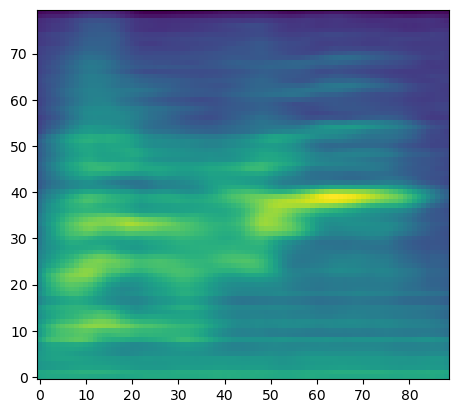

indi kl tensor(81.0997, device='cuda:1', grad_fn=<MeanBackward0>)


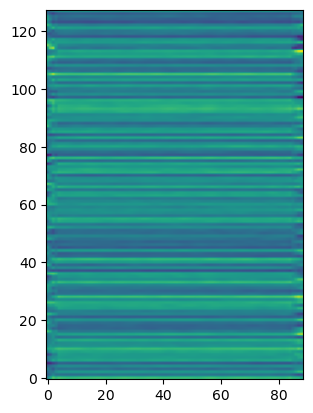

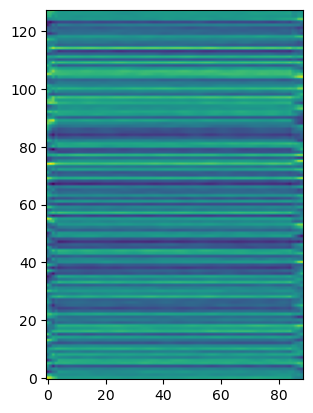

dy_kl tensor(0.0291, device='cuda:1', grad_fn=<MeanBackward0>)


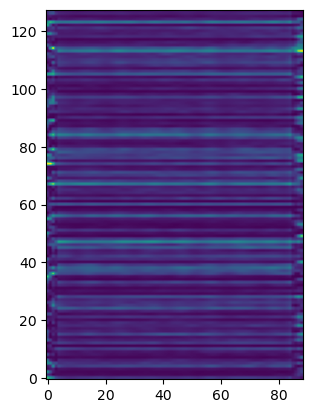

kl_dy_sumtime torch.Size([1, 89])
sorted_indices [40, 112, 36, 125, 24, 65, 47, 4, 25, 2, 11, 95, 98, 105, 56, 32, 99, 61, 30, 39, 70, 13, 77, 115, 8, 23, 7, 60, 37, 104, 64, 114, 33, 96, 89, 51, 123, 122, 84, 63, 118, 22, 45, 38, 68, 127, 62, 117, 97, 35, 46, 107, 29, 54, 90, 110, 80, 94, 124, 27, 87, 103, 106, 88, 78, 67, 6, 20, 41, 28, 17, 69, 26, 72, 126, 0, 81, 52, 34, 75, 120, 21, 58, 50, 16, 49, 3, 109, 19, 57, 116, 5, 73, 108, 1, 42, 93, 100, 74, 14, 86, 59, 92, 121, 101, 15, 76, 71, 82, 66, 43, 12, 79, 91, 9, 53, 44, 18, 102, 85, 10, 113, 55, 31, 111, 48, 119, 83]
sorted indi_mu [array([4.024333], dtype=float32), array([1.2385945], dtype=float32), array([1.1080875], dtype=float32), array([1.0181916], dtype=float32), array([0.9291179], dtype=float32), array([-0.2276322], dtype=float32), array([0.62147945], dtype=float32), array([0.75839645], dtype=float32), array([0.3580516], dtype=float32), array([0.52078456], dtype=float32), array([-0.29363826], dtype=float32), array([0.45395

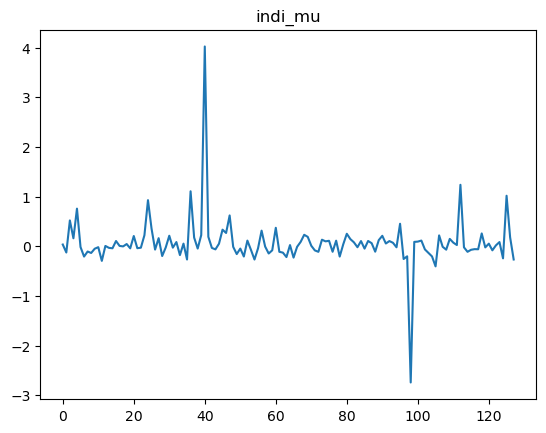

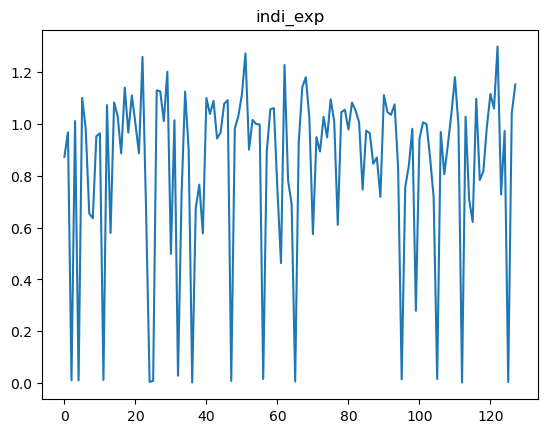

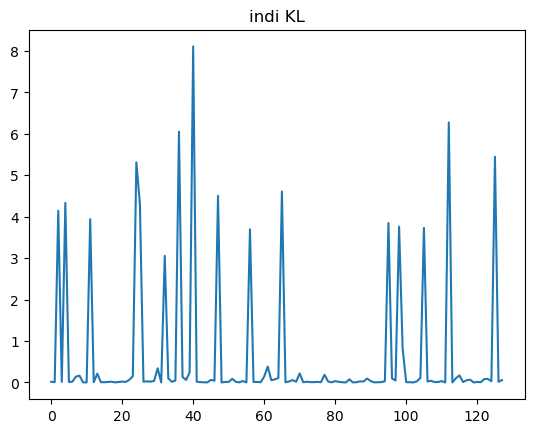

2 [0.52078456] [0.01101075] [4.1445518]
4 [0.75839645] [0.01062095] [4.3325663]
11 [-0.29363826] [0.01233192] [3.9387517]
24 [0.9291179] [0.004607] [5.3118196]
25 [0.3580516] [0.00870836] [4.30761]
32 [0.08546017] [0.0287118] [3.054511]
36 [1.1080875] [0.00263945] [6.0511155]
40 [4.024333] [1.0996674] [8.107254]
47 [0.62147945] [0.0081533] [4.502484]
56 [0.31555915] [0.01584206] [3.6950011]
65 [-0.2276322] [0.00620932] [4.607631]
95 [0.4539524] [0.01432853] [3.8486414]
98 [-2.7425761] [0.98116875] [3.7612188]
105 [-0.40443298] [0.01578509] [3.7305973]
112 [1.2385945] [0.00245849] [6.2752695]
125 [1.0181916] [0.00439271] [5.446175]
[2, 4, 11, 24, 25, 32, 36, 40, 47, 56, 65, 95, 98, 105, 112, 125]


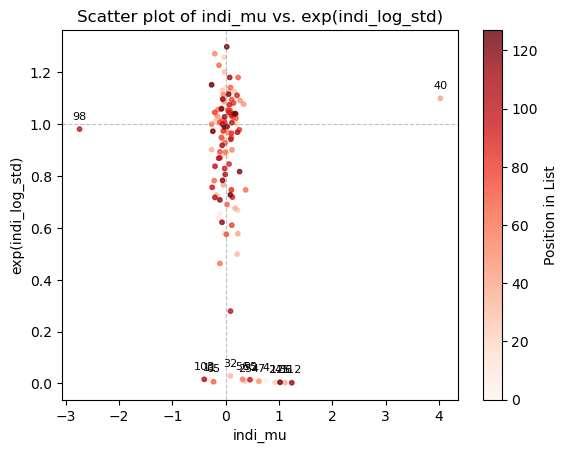

In [31]:

# model path
# model_config_path = "./Animal/configs/greatbird/model_greatbird.yaml"
#constrain bottleneck

# model path
model_config_path = "./Animal/configs/finch_bird2/model_finch_bird2.yaml"
model_path = './Animal/output/finch_bird2'
# model name
#------------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_1-c_100.0_1.0-i_10.0_100.0'
# checkpoint = "190000.pth.tar"
# key_posi = [10, 18, 22, 23, 24, 29, 34, 41, 44, 56, 57, 61, 63, 85, 87, 90, 92, 96, 116, 118, 121, 122, 127]
#------------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_1-c_100.0_0.75-i_10.0_100.0'
# checkpoint = "280000.pth.tar"
#------------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_2-c_100.0_1.1-i_10.0_60.0'
# checkpoint = "280000.pth.tar"
#------------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_4-c_100.0_0.5-i_10.0_80.0'
# checkpoint = "80000.pth.tar"
#------------------------------------------------------------------------
# exp_name = 'VAEbase-finch_bird2_5-c_100.0_0.1-i_10.0_20.0'
# checkpoint = "300000.pth.tar"
#------------------------------------------------------------------------
exp_name = 'VAEbase-finch_bird2_6-c_100.0_0.5-i_10.0_80.0'
checkpoint = "180000.pth.tar"

# model loading
model_config = yaml.load(open(model_config_path, "r"), Loader=yaml.FullLoader)
model_name = model_config['model_name']
model_type = getattr(models, model_name) # model choose
model = model_type(model_config, device).to(device) # model config load


#load model
save_path = os.path.join(model_path, exp_name, 'checkpoint', checkpoint)
ckpt = torch.load(save_path)
model.load_state_dict(ckpt["model"])
model.eval()
#--------------------------------------------------------------------------------

# Skip 'n' batches and then get the next one
mel, lenx, indi_mel, cID, cID_type = next(islice(analy_loader, 1054, None))

# 1490


# plot sepc
print('cID_type:',cID_type[0])
plt.imshow(mel[0], origin = 'lower')
plt.show()

# print('cID_type:',cID_type[0])
# plt.imshow(indi_mel[0], origin = 'lower')
# plt.show()

# test input model
mel = mel.to(device)
lenx = lenx.to(device)
indi_mel = indi_mel.to(device)

#--------------------------------------------------------------------------------
# random input
# indi_mel = torch.normal(mean = 1, std = 1, size=(1, 80, 256)).to(device)

# output of trained model
outputs = model(mel, lenx, indi_mel) 
z_indi_mu = outputs['indi_mu'].detach().cpu().numpy()
z_indi_log_std = outputs['indi_log_std'].detach().cpu().numpy()
z_indi = outputs['z_indi'].detach().cpu().numpy() 
z_con_mu = outputs['con_mu'].detach().cpu().numpy() 
z_con_log_std = outputs['con_log_std'].detach().cpu().numpy() 
z_con = outputs['z_con'].detach().cpu().numpy() 
x_rec = outputs['x_rec'].detach().cpu().numpy() 

# plot recon
print(z_indi_mu.shape)
print('reconstructed:',cID_type[0])
plt.imshow(x_rec[0], origin = 'lower')
plt.show()

# miu & sigma
print(z_indi_mu.shape)
print(np.mean(z_indi_mu))
#--------------------------------------------------------------------------------
# step load encoders
dy_mu, dy_std= model.dynamicEncoder(mel, lenx)
sta_mu, sta_log_std = model.staticEncoder(indi_mel)

# sample
z_dy = model.dynamicEncoder.sample(dy_mu, dy_std)
z_sta = model.staticEncoder.sample(sta_mu, sta_log_std)

# 修改z value
# z_sta = torch.zeros_like(z_sta)
value = [i for i in np.arange(-8, 4, 1)]
print(value)
for i in value:
    z_sta[:, 80] = i 
    print('z_sta',i)
    print('z_dy',z_dy.shape,'z_sta',z_sta.shape)
    # zero
    z_sta = torch.zeros_like(z_sta)
    # z_sta = torch.randn_like(z_sta)
    # z_dy = torch.zeros_like(z_dy)

    time_len = z_dy.size(2)
    z_sta_in = z_sta.unsqueeze(2).expand(-1, -1, time_len)

    dec_in = torch.cat([z_sta_in, z_dy], dim=1)
    x_rec = model.decoder(dec_in, lenx)

    print('shape',dy_mu.shape, sta_mu.shape)
    
    plt.imshow(x_rec[0].detach().cpu().numpy() , origin = 'lower')
    plt.show()
#--------------------------------------------------------------------------------
# indi KL
# formula
indi_kl = model.staticEncoder.kl_divergence(outputs['indi_mu'], outputs['indi_log_std'])
print('indi kl', indi_kl)
# step by step for KL
post = D.Normal(outputs['indi_mu'], torch.exp(outputs['indi_log_std']))
prior = D.Normal(
    torch.zeros_like(outputs['indi_mu'], requires_grad=False),
    torch.ones_like(torch.exp(outputs['indi_log_std']), requires_grad=False))
kl_indi = D.kl.kl_divergence(post, prior)
#--------------------------------------------------------------------------------
# dynamic KL
def sequence_mask(length, max_length=None):
    if max_length is None:
        max_length = length.max()
    x = torch.arange(max_length, dtype=length.dtype, device=length.device)
    return x.unsqueeze(0) < length.unsqueeze(1)

#--------------------------------------------------------------------------------
# plot mu std
# con_mu
plt.imshow(outputs['con_mu'][0].detach().cpu().numpy(), origin = 'lower')
plt.show()

# con_log_std
plt.imshow(outputs['con_log_std'][0].detach().cpu().numpy(), origin = 'lower' )
plt.show()

dy_kl = model.dynamicEncoder.kl_divergence(outputs['con_mu'], outputs['con_log_std'], lenx)
print('dy_kl',dy_kl)
#--------------------------------------------------------------------------------
# step by step for KL
mask = sequence_mask(lenx).to(outputs['con_mu'].dtype) # [batch, T] (all 1)
post_dy = D.Normal(outputs['con_mu'], torch.exp(outputs['con_log_std'])) # [batch, dim, T]
prior_dy = D.Normal(
    torch.zeros_like(outputs['con_mu'], requires_grad=False),
    torch.ones_like(outputs['con_log_std'], requires_grad=False)) # [batch, dim, T]
kl_dy = D.kl.kl_divergence(post_dy, prior_dy) # [batch, dim, T]
#--------------------------------------------------------------------------------
# plot kl matrix
plt.imshow(kl_dy[0].detach().cpu().numpy(), origin = 'lower')
plt.show()
#--------------------------------------------------------------------------------
kl_dy_sumtime = torch.sum(kl_dy, dim=1) * mask # [batch, T]


print('kl_dy_sumtime',kl_dy_sumtime.shape)

# dim 1 sum，*mask，dim 1 sum，divided by sum of mask
kl_dy = torch.sum(torch.sum(kl_dy, dim=1) * mask, dim=1) / torch.sum(mask, dim=1) # [batch, dim, T] -> [batch, T], /(sum(mask)), [batch, T] -> [batch]
kl_dy = torch.mean(kl_dy) # [batch] -> [1]

#--------------------------------------------------------------------------------
# plot miu & sigma
kl_indi = kl_indi.detach().cpu().numpy().T
indi_mu = outputs['indi_mu'].detach().cpu().numpy().T
indi_exp = torch.exp(outputs['indi_log_std']).detach().cpu().numpy().T

#--------------------------------------------------------------------------------
# 排序miu std unit的kl散度值
# print(kl[0])
sorted_indices = sorted(range(len(kl_indi)), key=lambda i: kl_indi[i], reverse=True)
print('sorted_indices',sorted_indices)
# print('sorted kl',[kl[i] for i in sorted_indices])
print('sorted indi_mu',[indi_mu[i] for i in sorted_indices])
print('sorted indi_exp',[indi_exp[i] for i in sorted_indices])

print('kl value',kl_indi)
print('kl shape', kl_indi.shape)
print('kl mean',kl_indi.mean())
print('kl sum',kl_indi.sum())
# kl = torch.mean(torch.sum(kl, dim=1))
#--------------------------------------------------------------------------------
plt.plot(indi_mu)
plt.title('indi_mu')
plt.show()

plt.plot(indi_exp)
plt.title('indi_exp')
plt.show()

plt.plot(kl_indi)
plt.title('indi KL')
plt.show()
#--------------------------------------------------------------------------------
# scatter plot
indices = np.arange(indi_mu.shape[0])
plt.scatter(indi_mu, indi_exp, s=10, c=indices, cmap='Reds', alpha=0.8)
plt.colorbar(label='Position in List')
plt.axhline(1, color='grey', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', alpha=0.5, linewidth=0.8)

key_index = []
for i, (x, y, k) in enumerate(zip(indi_mu, indi_exp, kl_indi)):
    if k >= 1:
        key_index.append(i)
        print(i,x,y,kl_indi[i])
        plt.text(x, y + 0.03, f'{i}', fontsize=8, ha='center', va='bottom')


print(key_index)

plt.title('Scatter plot of indi_mu vs. exp(indi_log_std)')
plt.xlabel('indi_mu')
plt.ylabel('exp(indi_log_std)')
plt.show()

# print(outputs['indi_mu'])
# print(torch.exp(outputs['indi_log_std']))
# print(torch.zeros_like(outputs['indi_mu'], requires_grad=False))
# print(prior)


(21591, 128)


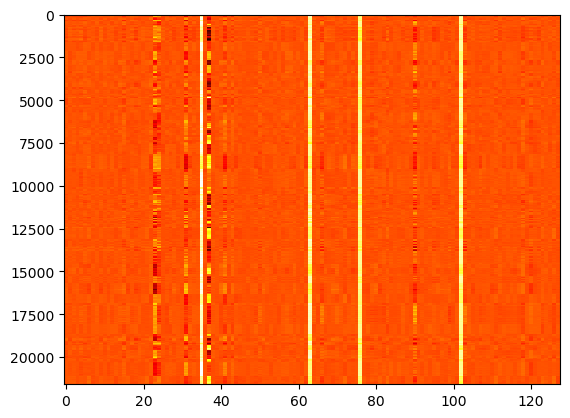

23


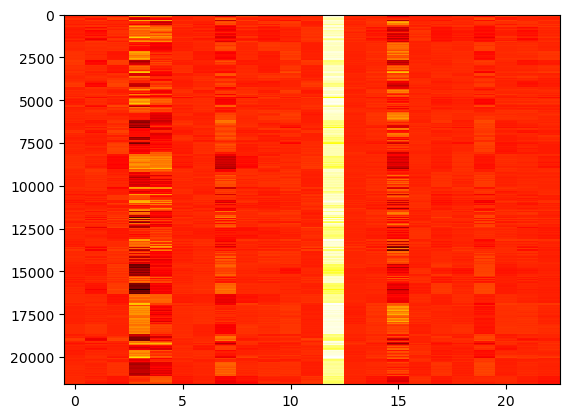

unique_caller_type 0
unique_caller_type 0
unique_caller_type 0
unique_caller_type 0
unique_caller_type 0
unique_caller_type 0
unique_caller_type 0
unique_caller_type 0
unique_caller_type 0
unique_caller_type 0
unique_caller_type 0
total caller_miu_sum (0,)
caller_miu_sum (0,)


TypeError: Invalid shape (0,) for image data

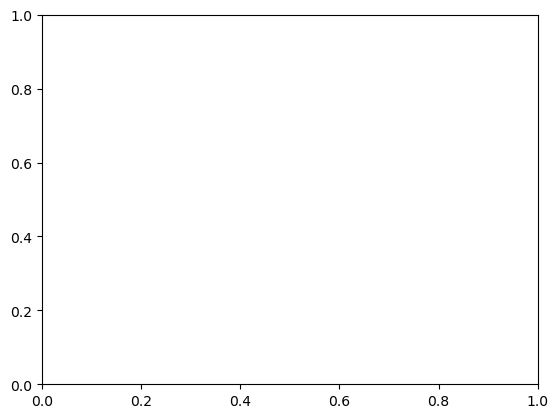

In [32]:


from logging import handlers


key_posi = [10, 18, 22, 23, 24, 29, 34, 41, 44, 56, 57, 61, 63, 85, 87, 90, 92, 96, 116, 118, 121, 122, 127]

# total_z_indi = np.array(total_z_indi).squeeze() # indi
# total_z_indi_mu = np.array(total_z_indi_mu).squeeze() # individual miu
# total_z_indi_log_std = np.array(total_z_indi_log_std).squeeze()

print(total_z_indi_mu.shape)
total_key_indi_z = [seg[key_posi] for seg in total_z_indi_mu]
total_key_indi_z_sta = [seg[key_posi] for seg in total_z_indi_log_std]


# plot miu std
plt.imshow(total_z_indi_mu, aspect='auto', cmap='hot', interpolation='nearest')
plt.show()
# plt.imshow(total_z_indi_log_std, aspect='auto', cmap='hot', interpolation='nearest')
# plt.show()


# plot key miu std
print(len(total_key_indi_z[0]))
plt.imshow(total_key_indi_z, aspect='auto', cmap='hot', interpolation='nearest')
plt.show()
# plt.imshow(total_key_indi_z_sta, aspect='auto', cmap='hot', interpolation='nearest')
# plt.show()


# for i in range(len(total_key_indi_z)):
#     plt.plot(total_key_indi_z[i])
# plt.show()


# plot spectrogram
# used_caller = ['B101', 'B165', 'B221', 'B39', 'B4s

used_caller = ['B101', 'B165', 'B221', 'B39', 'B4','B57', 'B67', 'B98', 'C1','C10', 'C108']
# ['B101', 'B165', 'B221', 'B39', 'B4','B57', 'B67', 'B98', 'C1' ,'C10', 'C108',
#  'C109' ,'C12', 'C16', 'C4', 'C47', 'C61A' ,'EX10' ,'EX19A' ,'EX29', 'EX34', 'EX51',
#  'EX57', 'EX62', 'EX62E', 'EX62F', 'MP12', 'MP29' ,'MP41', 'MP42' ,'MP50' ,'MP55',
#  'MP57', 'MP61', 'MP64', 'MP65' ,'MP76' ,'MP78' ,'O113' ,'O21', 'O27A' ,'O36', 'O48',
#  'O56', 'O6', 'O75D' ,'O78', 'O82', 'O93', 'P11', 'P6' ,'SW1', 'SW102', 'SW114',
#  'SW128', 'SW19' ,'SW28', 'SW32' ,'SW34', 'SW49' ,'SW60', 'SW9' ,'W103A' ,'W17',
#  'W18' ,'W28', 'W35', 'W36', 'W67' ,'W73' ,'W80']


max_index = 200
caller_miu_sum = []
caller_std_sum = []
total_caller_type = []
for caller in used_caller:
    # caller id
    mask_caller = np.isin(total_cID, caller)
    caller_indices = np.where(mask_caller)[0]
    # print(caller_indices)
    # caller type 
    
    
    unique_caller_type = np.unique(total_ctID[caller_indices])
    
    print('unique_caller_type',len(unique_caller_type))
    for type in unique_caller_type:
        mask_caller_type = np.isin(total_ctID, type)
        caller_type_indices = np.where(mask_caller_type)[0]
        # print('caller_type_indices',caller_type_indices)
        index = 0
        
        caller_type_miu_sum = []
        caller_type_std_sum = []
        
        for i in caller_type_indices:
            # print('{}, num {}'.format(total_ctID[i], index))
            
            caller_type_miu_sum.append(total_key_indi_z[i])
            caller_type_std_sum.append(total_key_indi_z_sta[i])
            
            # plt.imshow(total_x_gt[i][0], origin = 'lower')
            # plt.title('{}, num {}'.format(total_ctID[i], index))  
            # plt.show()
            if index + 1 >= max_index:
                break
            index += 1
        
        
        print(type, np.array(caller_type_miu_sum).shape)
        
        caller_type_miu_sum_mean = np.array(caller_type_miu_sum).mean(axis = 0)
        caller_miu_sum.append(caller_type_miu_sum_mean)
        
        caller_type_std_sum_mean = np.array(caller_type_std_sum).mean(axis = 0)
        caller_std_sum.append(caller_type_std_sum_mean)

        total_caller_type.append(type)
    
    # print(len(caller_std_sum))
# total_caller_type.tolist()
    
print('total caller_miu_sum', np.array(caller_miu_sum).shape)


for i in range(len(caller_miu_sum)):
    plt.plot(caller_miu_sum[i])
plt.show()

# for i in range(len(caller_std_sum)):
#     plt.plot(caller_std_sum[i])
# plt.show()


# 画sum vector图
caller_miu_sum = np.array(caller_miu_sum)
print('caller_miu_sum',caller_miu_sum.shape)

plt.imshow(caller_miu_sum, aspect='auto', cmap='hot', interpolation='nearest')
# plt.legend(handles=total_caller_type)
plt.show()

# plt.imshow(caller_std_sum, aspect='auto', cmap='hot', interpolation='nearest')
# plt.show()


tsne = TSNE(n_components=2, perplexity = 10, n_iter = 1000)
data_2d = tsne.fit_transform(caller_miu_sum)

print(data_2d.shape)

y = total_caller_type


for i in range(len(np.unique(y))):
    # print(y, y[i])
    
    mask_caller = np.isin(y, y[i])
    caller_indices = np.where(mask_caller)[0]
    # print('mask_caller', mask_caller)
    # print('caller_indices', caller_indices)

    # print(caller_indices)
    plt.scatter(data_2d[caller_indices, 0], data_2d[caller_indices, 1], label='{}'.format(y[i]))
    
    # centroid = np.median(data_2d[i,:], axis=0)
    # plt.text(data_2d[caller_indices, 0], data_2d[caller_indices, 1], str(y[i]), fontsize=6, color='black', ha='center', va='center')
    plt.text(data_2d[caller_indices, 0], data_2d[caller_indices, 1], str(y[i].split('_')[0]), fontsize=10, color='black', ha='center', va='center')
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)
plt.show()
# for label in total_caller_type:
#     # label_mask = np.all(total_caller_type == label, axis=0)
#     # print('label_mask',label_mask)
#     # data_for_label = data_2d[label_mask]
    
#     print(data_2d)
#     # Plot the data for this label with a label for the legend
#     plt.scatter(data_2d[:, 0], data_2d[:, 1], label=label, alpha=0.5, s=8)

    # center prosition
    # centroid = np.median(data_2d, axis=0)
    # text label
    # plt.text(centroid[0], centroid[1], str(label), fontsize=6, color='black', ha='center', va='center')


# Add a legend
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=6)



